# Model Explainability and Export

This notebook generates explainability insights for the trained LightGBM model using SHAP (SHapley Additive exPlanations).

**Objectives:**
- Load trained model and test data from previous notebook
- Initialize SHAP TreeExplainer for LightGBM
- Compute SHAP values for test set
- Generate global SHAP summary plot (beeswarm plot)
- Generate SHAP summary bar plot (mean absolute SHAP values)
- Create Partial Dependence Plots for top 5 most important features
- Document interpretation guidelines
- Save SHAP explainer for deployment

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import lightgbm as lgb
import shap
import joblib
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Initialize SHAP JavaScript visualization
shap.initjs()

## 1. Load Trained Model and Test Data

We'll load the trained LightGBM model and regenerate the test data from the preprocessing pipeline.

In [2]:
# Load the marine engine fault dataset
df = pd.read_csv('../data/marine_engine_fault_dataset.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Total records: {len(df):,}")

# Define the 18 sensor feature columns
sensor_features = [
    'Shaft_RPM', 'Engine_Load', 'Fuel_Flow', 'Air_Pressure', 'Ambient_Temp',
    'Oil_Temp', 'Oil_Pressure', 'Vibration_X', 'Vibration_Y', 'Vibration_Z',
    'Cylinder1_Pressure', 'Cylinder1_Exhaust_Temp',
    'Cylinder2_Pressure', 'Cylinder2_Exhaust_Temp',
    'Cylinder3_Pressure', 'Cylinder3_Exhaust_Temp',
    'Cylinder4_Pressure', 'Cylinder4_Exhaust_Temp'
]

# Separate features and target
X = df[sensor_features].copy()
y = df['Fault_Label'].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Dataset loaded: (10000, 20)
Total records: 10,000

Features shape: (10000, 18)
Target shape: (10000,)


In [3]:
# Split data: 80% train, 20% test with stratification (same as training notebook)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Data Split:")
print("=" * 80)
print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Data Split:
Training set: 8,000 samples
Test set: 2,000 samples


In [4]:
# Load the saved preprocessor and transform data
preprocessor_path = '../backend/artifacts/preprocessor.pkl'
scaler = joblib.load(preprocessor_path)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for better SHAP visualization
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=sensor_features, index=X_test.index)

print(f"âœ“ Preprocessor loaded from: {preprocessor_path}")
print(f"âœ“ Test data scaled: {X_test_scaled.shape}")

âœ“ Preprocessor loaded from: ../backend/artifacts/preprocessor.pkl
âœ“ Test data scaled: (2000, 18)


In [5]:
# Load the trained LightGBM model
model_path = '../backend/artifacts/lgbm_model.pkl'
model = joblib.load(model_path)

print(f"\nâœ“ Model loaded from: {model_path}")
print(f"\nModel details:")
print("=" * 80)
print(f"Number of features: {model.n_features_in_}")
print(f"Number of classes: {model.n_classes_}")
print(f"Number of estimators: {model.n_estimators}")


âœ“ Model loaded from: ../backend/artifacts/lgbm_model.pkl

Model details:
Number of features: 18
Number of classes: 8
Number of estimators: 343


In [6]:
# Define fault label mapping
FAULT_LABELS = {
    0: "Normal",
    1: "Fuel Injection Fault",
    2: "Cooling System Fault",
    3: "Turbocharger Fault",
    4: "Bearing Wear",
    5: "Lubrication Oil Degradation",
    6: "Air Intake Restriction",
    7: "Vibration Anomaly"
}

print("Fault Label Mapping:")
print("=" * 80)
for label_id, label_name in FAULT_LABELS.items():
    print(f"  {label_id}: {label_name}")

Fault Label Mapping:
  0: Normal
  1: Fuel Injection Fault
  2: Cooling System Fault
  3: Turbocharger Fault
  4: Bearing Wear
  5: Lubrication Oil Degradation
  6: Air Intake Restriction
  7: Vibration Anomaly


## 2. Initialize SHAP TreeExplainer

SHAP (SHapley Additive exPlanations) provides a unified measure of feature importance based on game theory. TreeExplainer is optimized for tree-based models like LightGBM.

In [7]:
# Initialize SHAP TreeExplainer with the LightGBM model
print("Initializing SHAP TreeExplainer...")
print("=" * 80)

explainer = shap.TreeExplainer(model)

print("âœ“ SHAP TreeExplainer initialized successfully")
print(f"\nExplainer details:")
print(f"  Model type: {type(model).__name__}")
print(f"  Expected value shape: {np.array(explainer.expected_value).shape}")
print(f"  Number of outputs: {len(explainer.expected_value) if isinstance(explainer.expected_value, (list, np.ndarray)) else 1}")

Initializing SHAP TreeExplainer...


âœ“ SHAP TreeExplainer initialized successfully

Explainer details:
  Model type: LGBMClassifier
  Expected value shape: (8,)
  Number of outputs: 8


## 3. Compute SHAP Values for Test Set

Computing SHAP values for all test samples. This may take a few minutes depending on the test set size.

In [8]:
# Compute SHAP values for the test set
print("Computing SHAP values for test set...")
print("=" * 80)
print(f"Test set size: {len(X_test_scaled):,} samples")
print(f"Number of features: {X_test_scaled.shape[1]}")
print("\nThis may take a few minutes...\n")

shap_values_raw = explainer.shap_values(X_test_scaled)

print("âœ“ SHAP values computed successfully")
print(f"\nSHAP values shape: {np.array(shap_values_raw).shape}")

# Convert SHAP values to list format for compatibility with SHAP plots
# If shape is (samples, features, classes), transpose to list of (samples, features)
if isinstance(shap_values_raw, np.ndarray) and len(shap_values_raw.shape) == 3:
    print(f"  Format: (num_samples, num_features, num_classes)")
    print(f"  Converting to list format for visualization...")
    shap_values = [shap_values_raw[:, :, i] for i in range(shap_values_raw.shape[2])]
    print(f"  Converted to list of {len(shap_values)} arrays")
elif isinstance(shap_values_raw, list):
    print(f"  Format: list of (num_samples, num_features) arrays")
    shap_values = shap_values_raw
else:
    shap_values = shap_values_raw

print(f"\nFinal SHAP values format:")
print(f"  Classes: {len(shap_values)}")
print(f"  Samples per class: {shap_values[0].shape[0]:,}")
print(f"  Features: {shap_values[0].shape[1]}")

Computing SHAP values for test set...
Test set size: 2,000 samples
Number of features: 18

This may take a few minutes...



âœ“ SHAP values computed successfully

SHAP values shape: (2000, 18, 8)
  Format: (num_samples, num_features, num_classes)
  Converting to list format for visualization...
  Converted to list of 8 arrays

Final SHAP values format:
  Classes: 8
  Samples per class: 2,000
  Features: 18


## 4. Global SHAP Summary Plot (Beeswarm Plot)

The beeswarm plot shows:
- **Y-axis**: Features ranked by importance
- **X-axis**: SHAP value (impact on model output)
- **Color**: Feature value (red = high, blue = low)
- **Density**: Distribution of SHAP values across all samples

This visualization helps identify which features are most important globally and how their values affect predictions.

Generating SHAP summary plots for all fault classes...


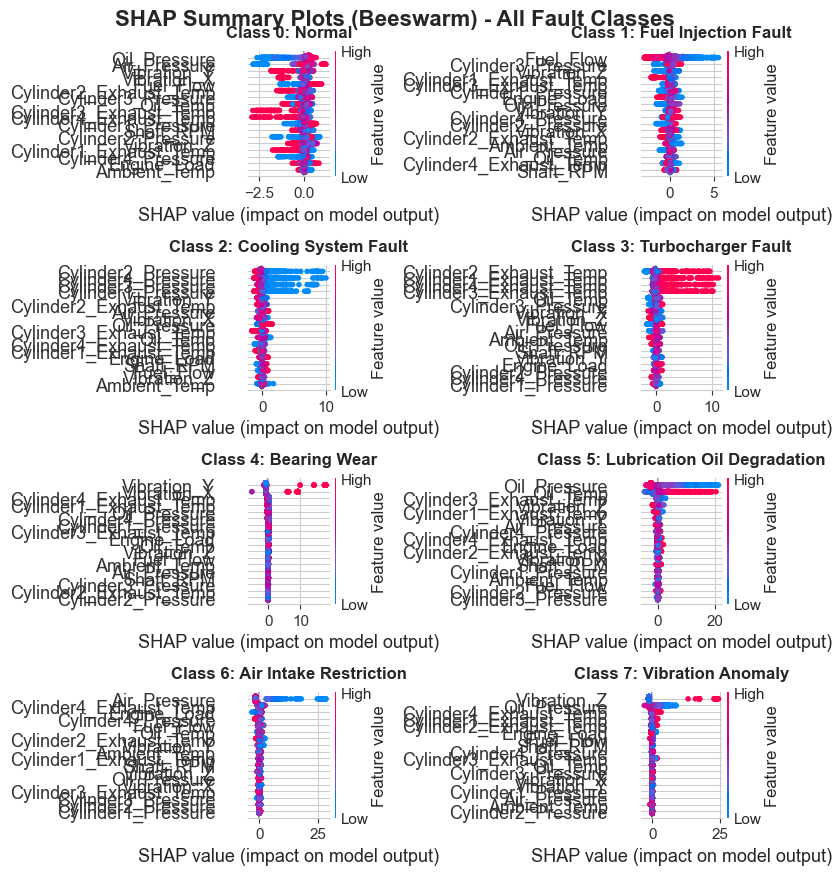


âœ“ SHAP beeswarm plots generated for all 8 fault classes


In [9]:
# Generate SHAP summary plot (beeswarm) for each class
print("Generating SHAP summary plots for all fault classes...")
print("=" * 80)

# Create a figure with subplots for each class
fig, axes = plt.subplots(4, 2, figsize=(20, 24))
axes = axes.flatten()

for class_idx in range(8):
    plt.sca(axes[class_idx])
    shap.summary_plot(
        shap_values[class_idx],
        X_test,  # Use original unscaled data for better interpretability
        plot_type="dot",
        show=False,
        max_display=18
    )
    axes[class_idx].set_title(f'Class {class_idx}: {FAULT_LABELS[class_idx]}',
                             fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.suptitle('SHAP Summary Plots (Beeswarm) - All Fault Classes',
            fontsize=16, fontweight='bold', y=1.001)
plt.show()

print("\nâœ“ SHAP beeswarm plots generated for all 8 fault classes")

## 5. SHAP Summary Bar Plot (Mean Absolute SHAP Values)

The bar plot shows the average magnitude of each feature's impact across all predictions, providing a clear ranking of global feature importance.

Generating SHAP bar plots (mean absolute values)...


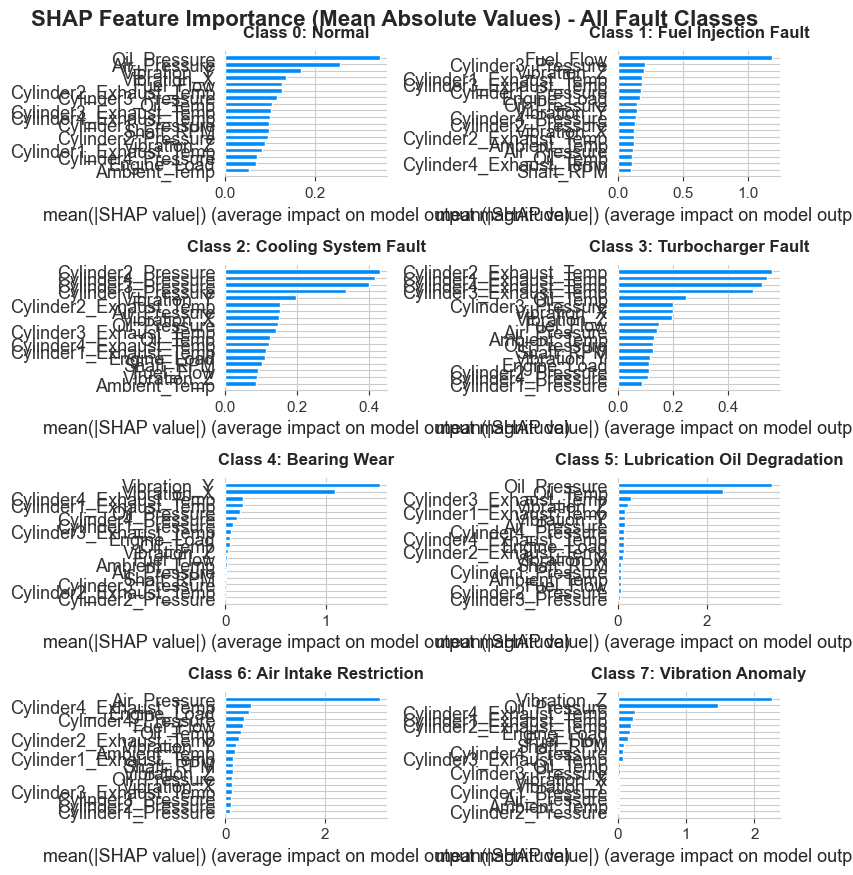


âœ“ SHAP bar plots generated for all 8 fault classes


In [10]:
# Generate SHAP summary bar plot for each class
print("Generating SHAP bar plots (mean absolute values)...")
print("=" * 80)

fig, axes = plt.subplots(4, 2, figsize=(20, 24))
axes = axes.flatten()

for class_idx in range(8):
    plt.sca(axes[class_idx])
    shap.summary_plot(
        shap_values[class_idx],
        X_test,  # Use original unscaled data
        plot_type="bar",
        show=False,
        max_display=18
    )
    axes[class_idx].set_title(f'Class {class_idx}: {FAULT_LABELS[class_idx]}',
                             fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.suptitle('SHAP Feature Importance (Mean Absolute Values) - All Fault Classes',
            fontsize=16, fontweight='bold', y=1.001)
plt.show()

print("\nâœ“ SHAP bar plots generated for all 8 fault classes")

In [11]:
# Calculate and display top 5 most important features globally
print("\nTop 5 Most Important Features (Global Average):")
print("=" * 80)

# Calculate mean absolute SHAP values across all classes and samples
mean_abs_shap = np.mean([np.abs(shap_values[i]).mean(axis=0) for i in range(8)], axis=0)

# Create DataFrame for ranking
feature_importance_df = pd.DataFrame({
    'Feature': sensor_features,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print(feature_importance_df.head(10).to_string(index=False))

# Store top 5 features for PDP
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
print(f"\nTop 5 features for Partial Dependence Plots: {top_5_features}")


Top 5 Most Important Features (Global Average):
               Feature  Mean_Abs_SHAP
          Oil_Pressure       0.750178
          Air_Pressure       0.494304
              Oil_Temp       0.418282
           Vibration_Z       0.405158
           Vibration_Y       0.321582
             Fuel_Flow       0.268442
           Vibration_X       0.249526
Cylinder4_Exhaust_Temp       0.242200
Cylinder1_Exhaust_Temp       0.205657
Cylinder2_Exhaust_Temp       0.195065

Top 5 features for Partial Dependence Plots: ['Oil_Pressure', 'Air_Pressure', 'Oil_Temp', 'Vibration_Z', 'Vibration_Y']


## 6. Partial Dependence Plots (PDP) for Top 5 Features

Partial Dependence Plots show the marginal effect of a feature on the predicted outcome, averaging out the effects of all other features. This helps understand the relationship between feature values and predictions.

Generating Partial Dependence Plots for top 5 features...

Generating PDP for Class 0: Normal


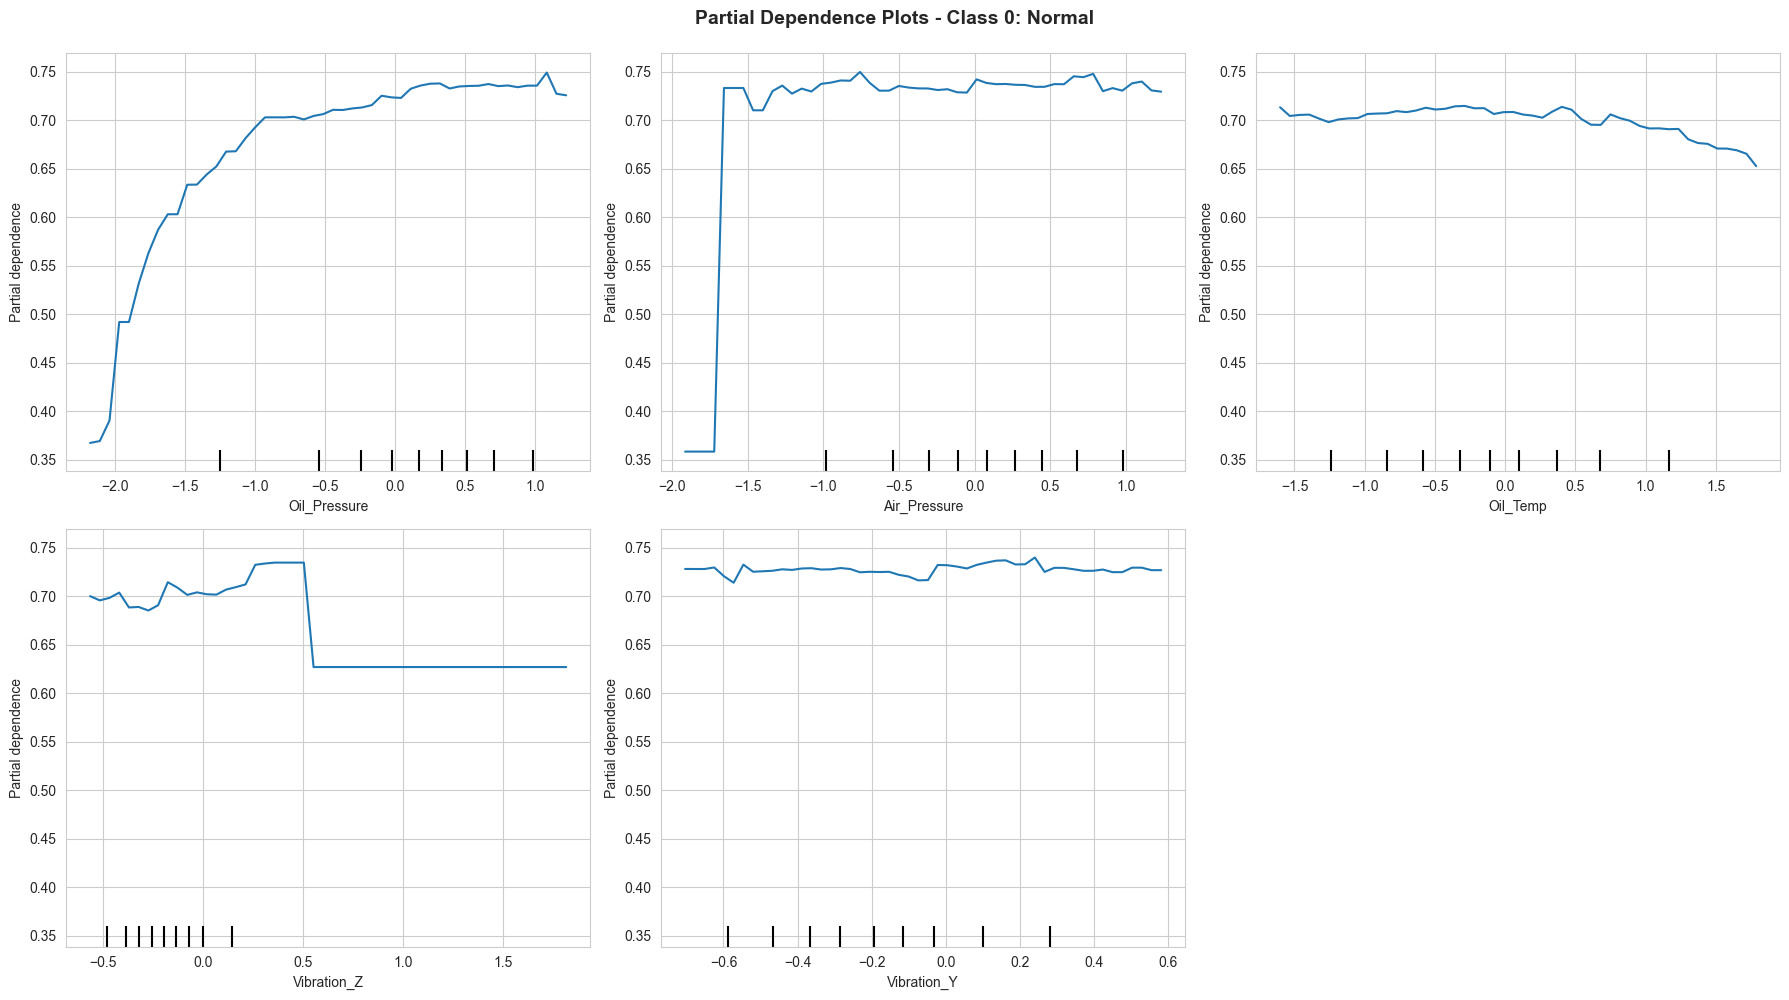


Generating PDP for Class 1: Fuel Injection Fault


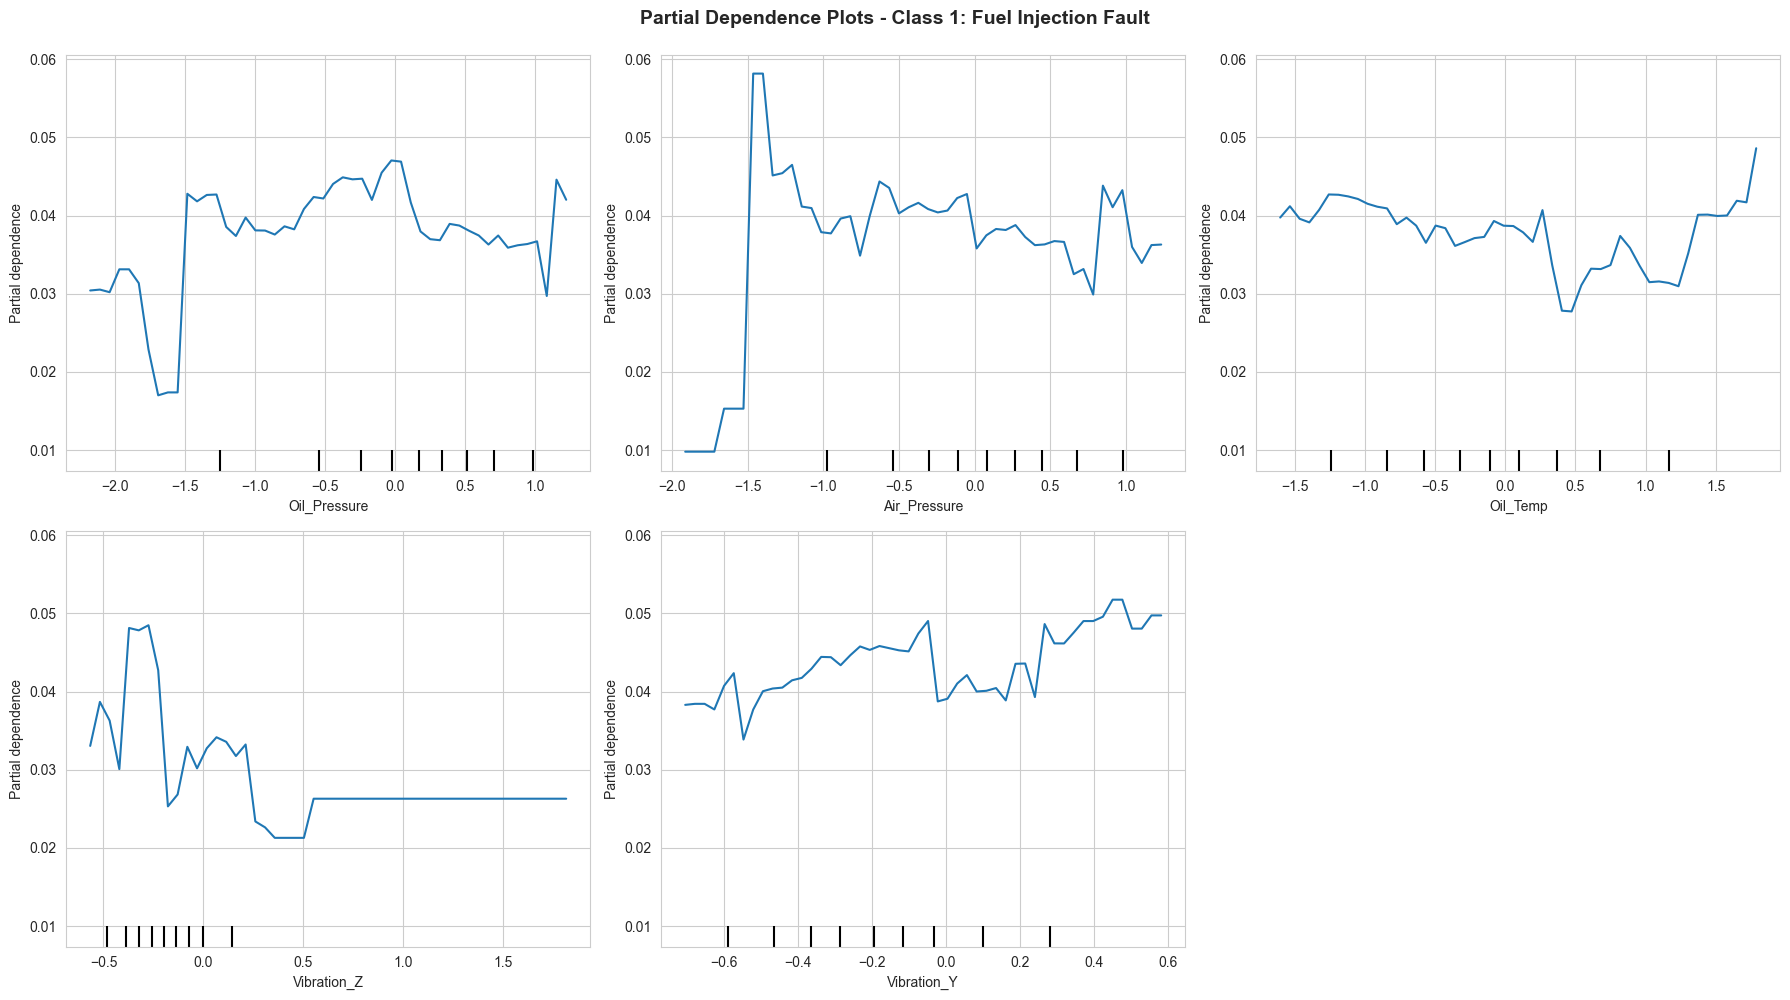


Generating PDP for Class 2: Cooling System Fault


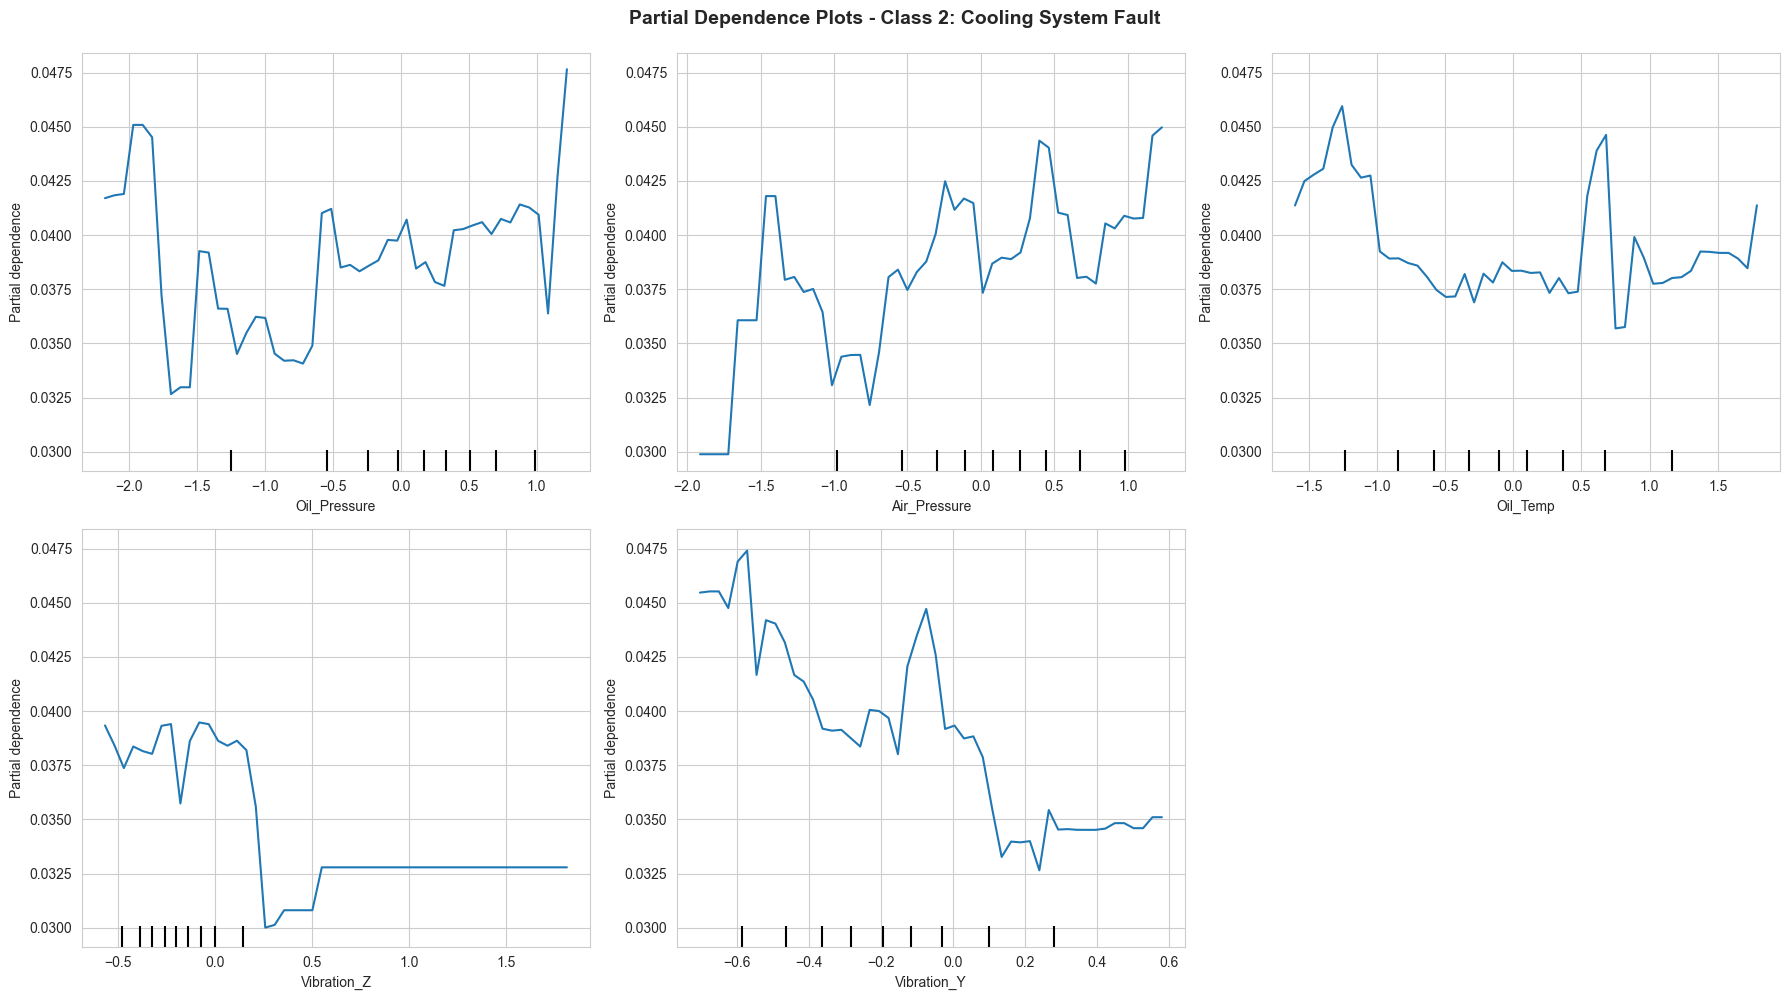


Generating PDP for Class 3: Turbocharger Fault


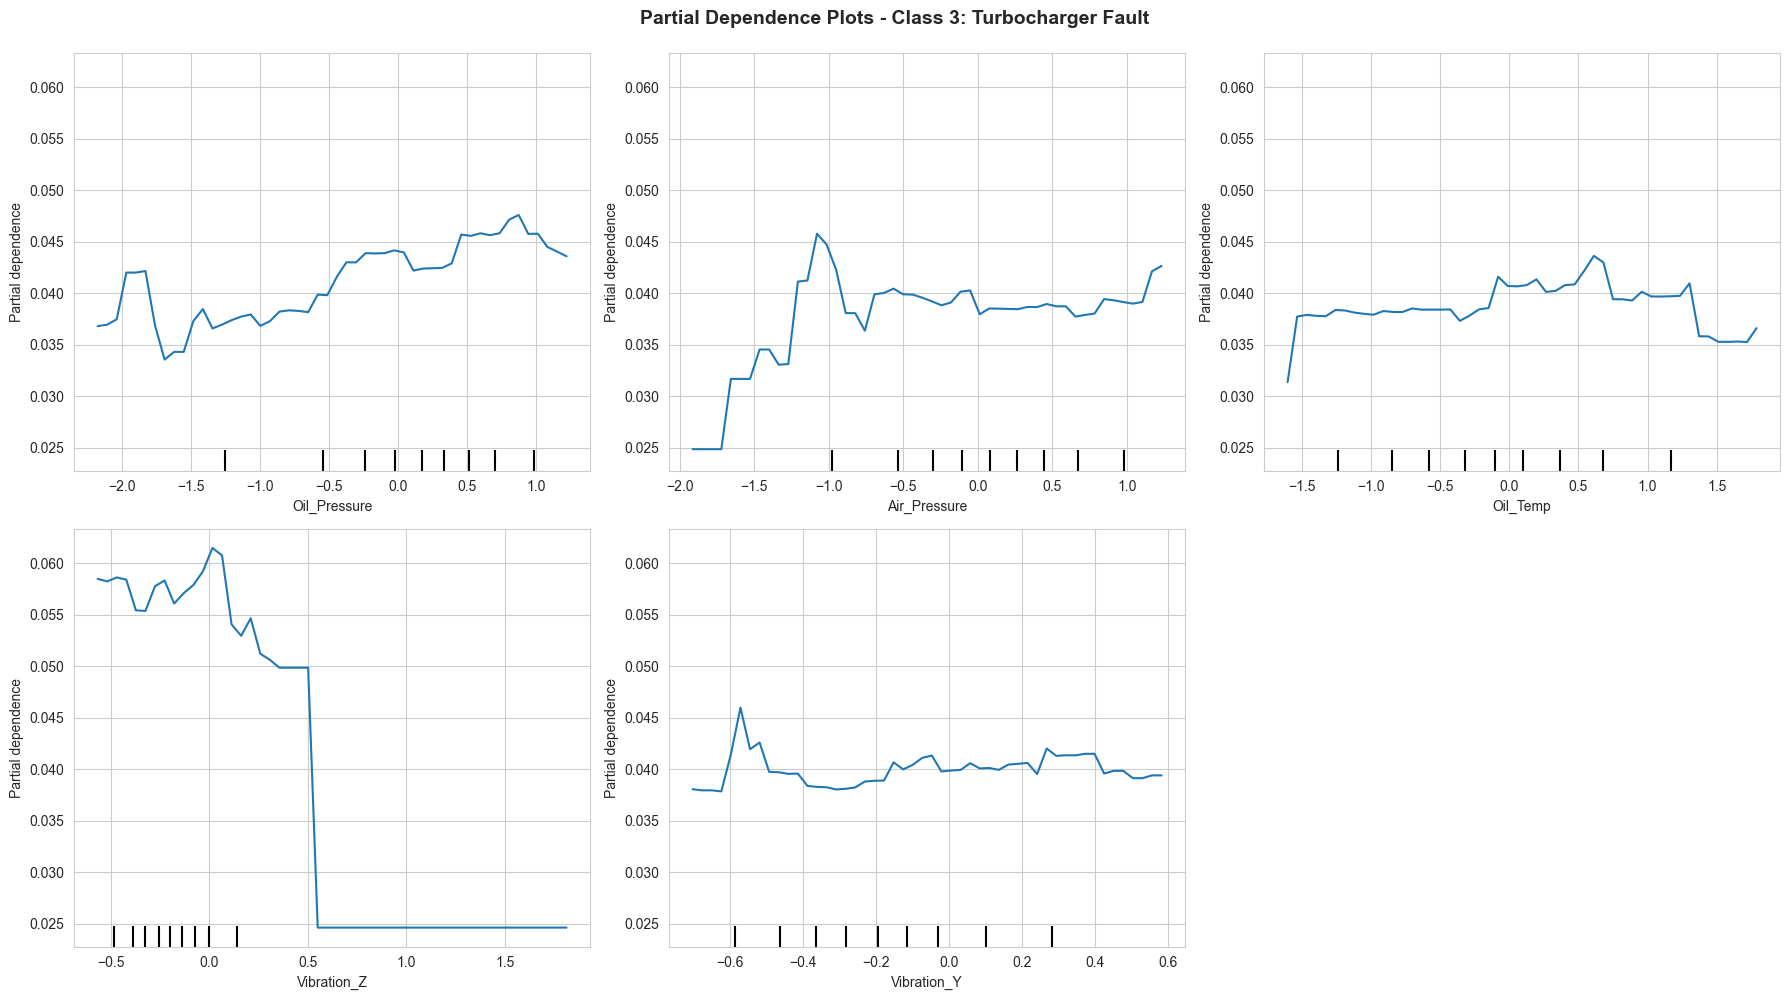


Generating PDP for Class 4: Bearing Wear


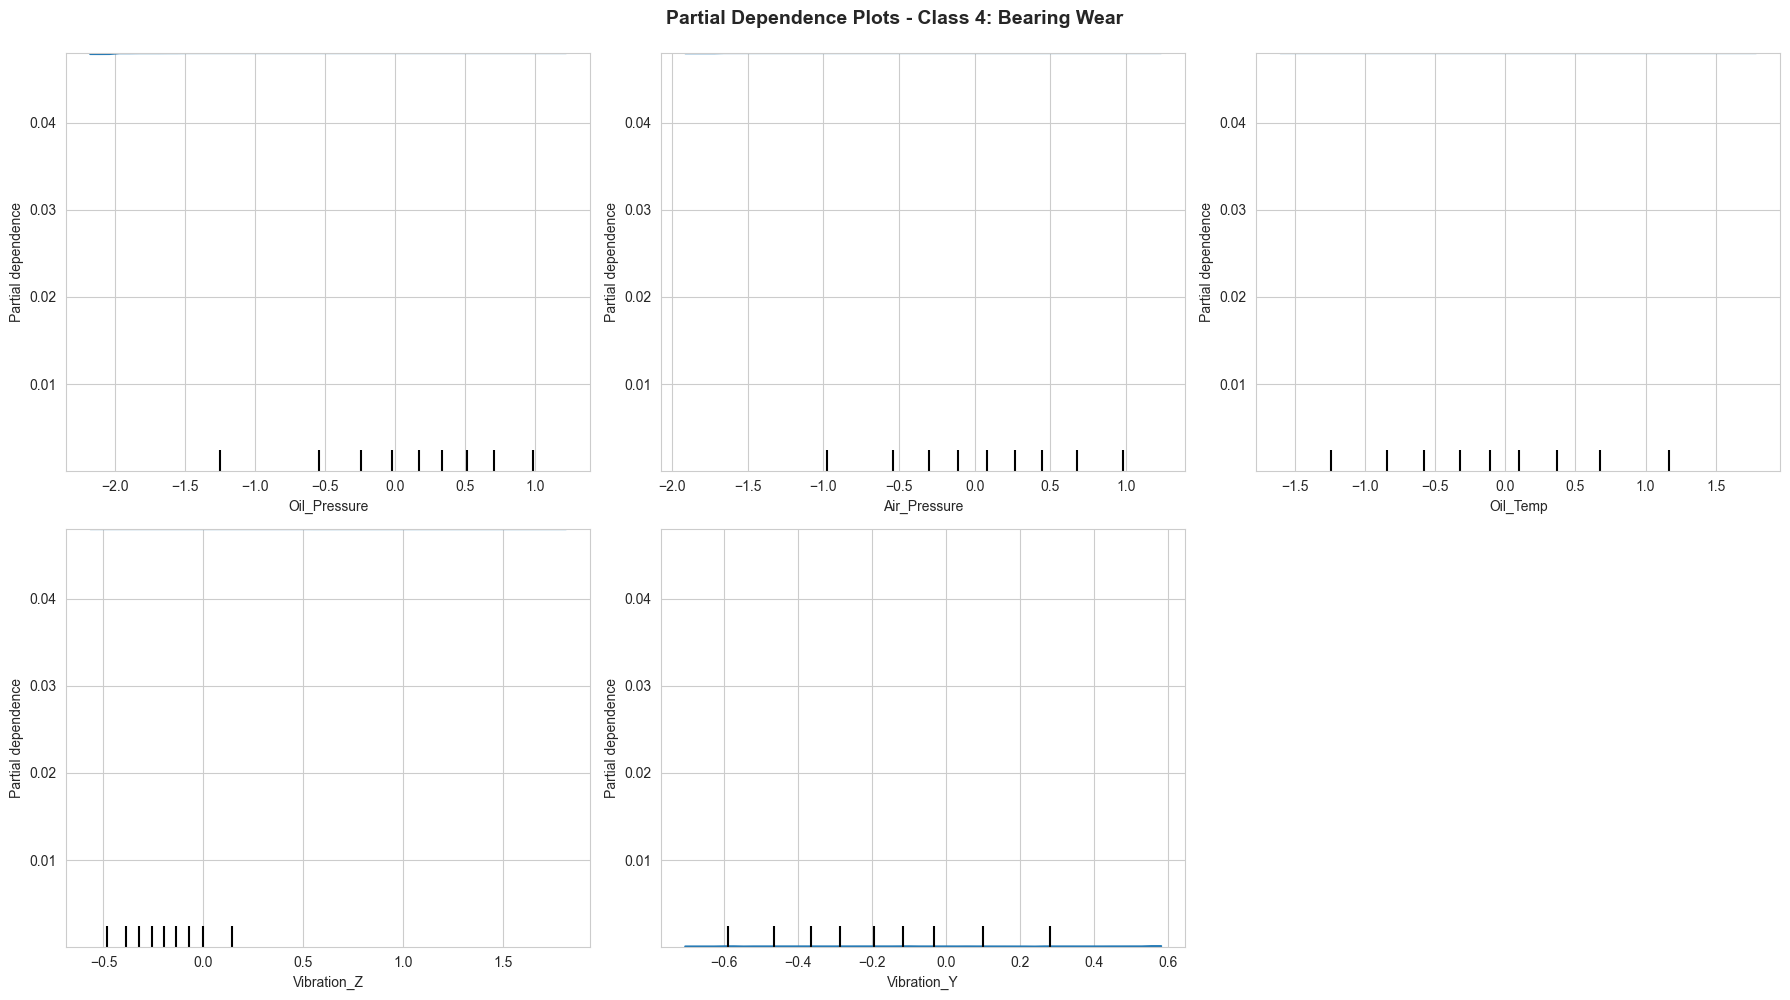


Generating PDP for Class 5: Lubrication Oil Degradation


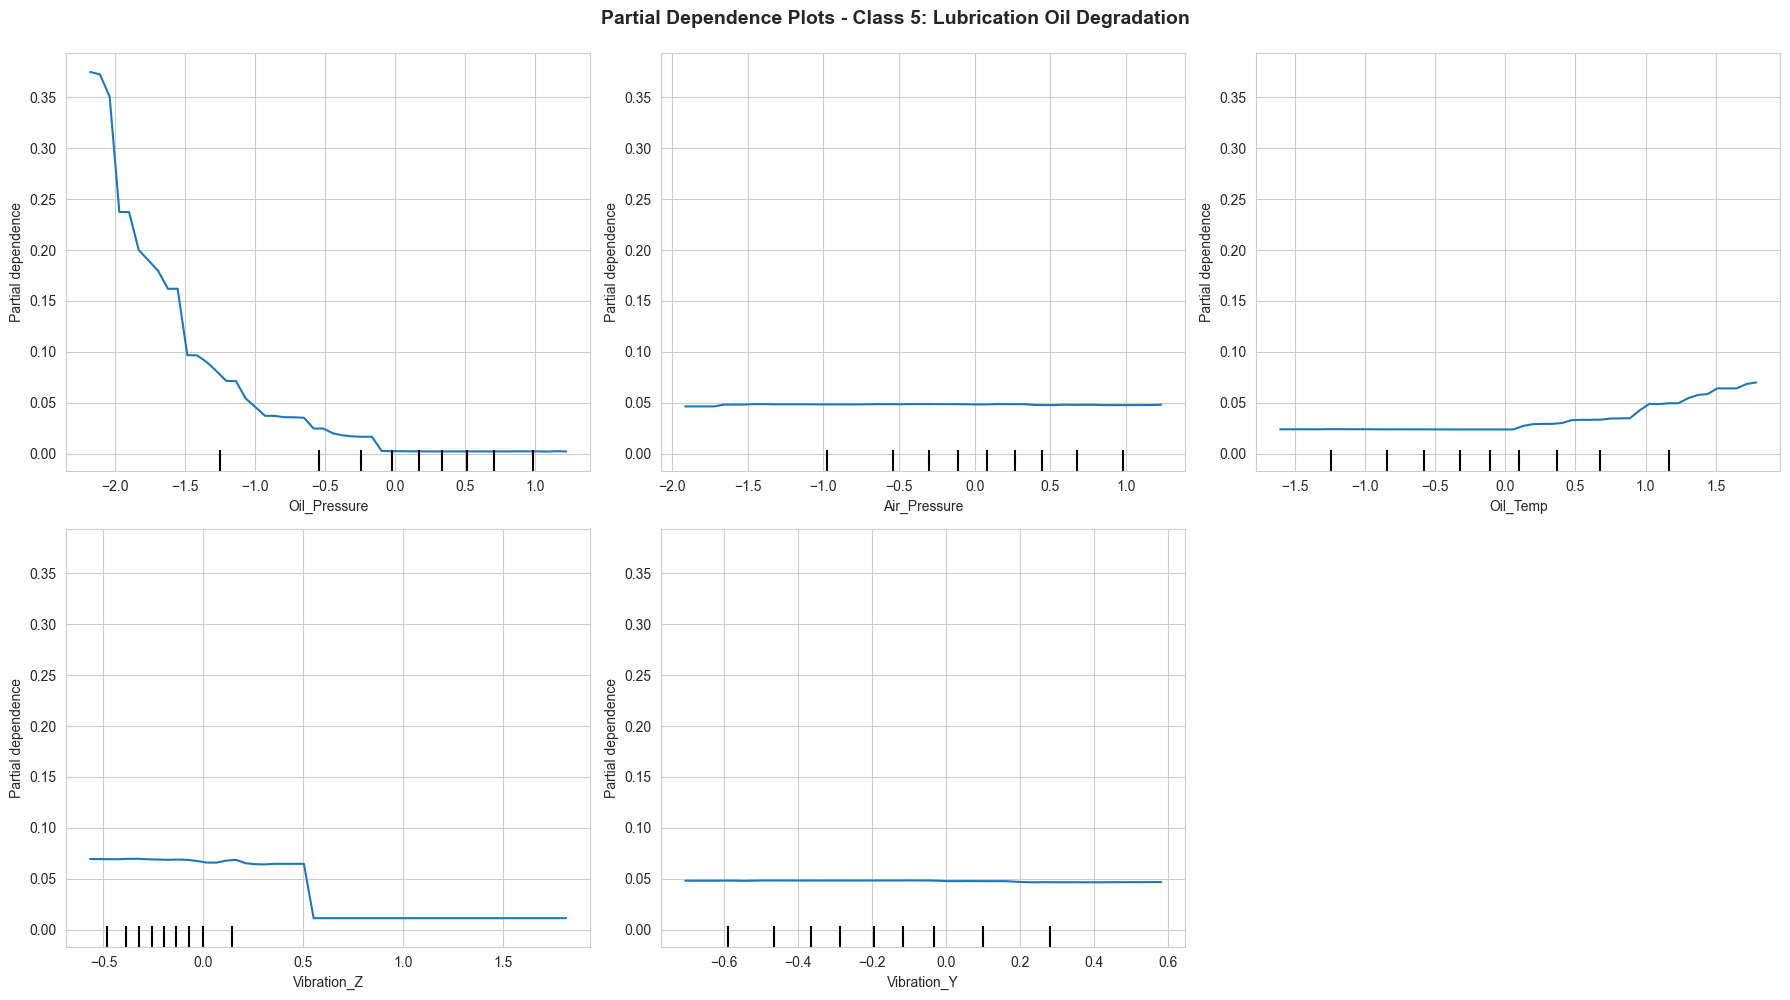


Generating PDP for Class 6: Air Intake Restriction


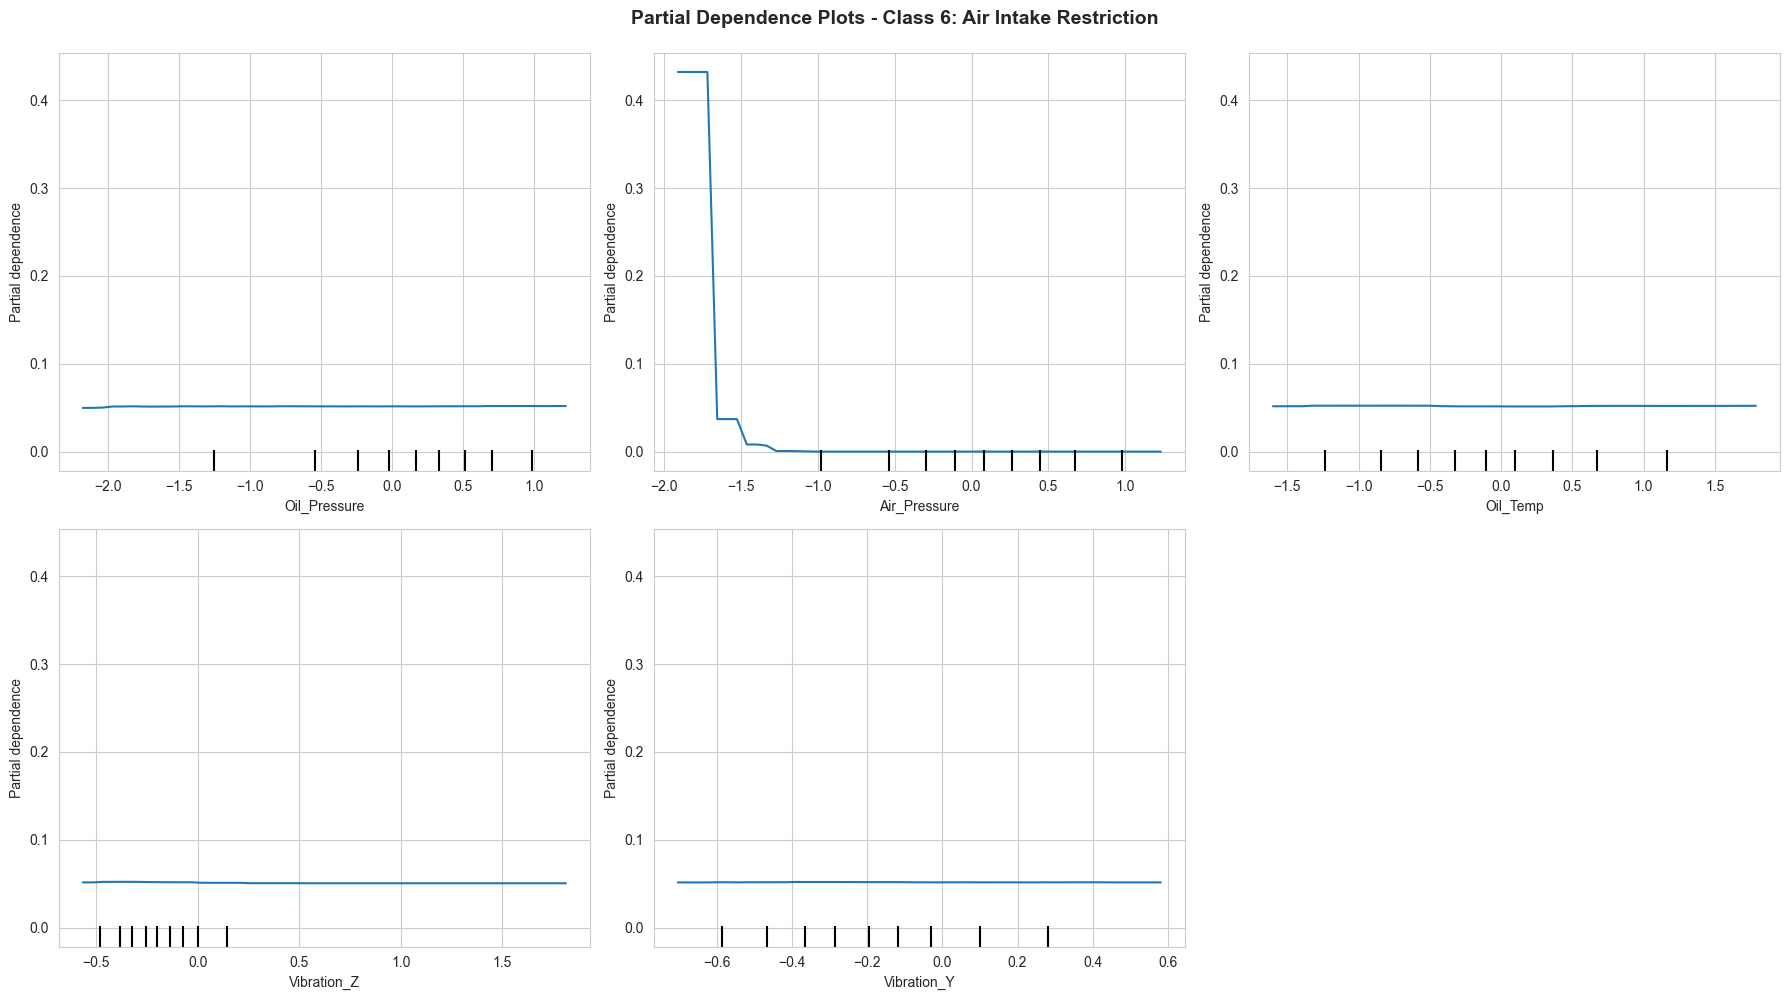


Generating PDP for Class 7: Vibration Anomaly


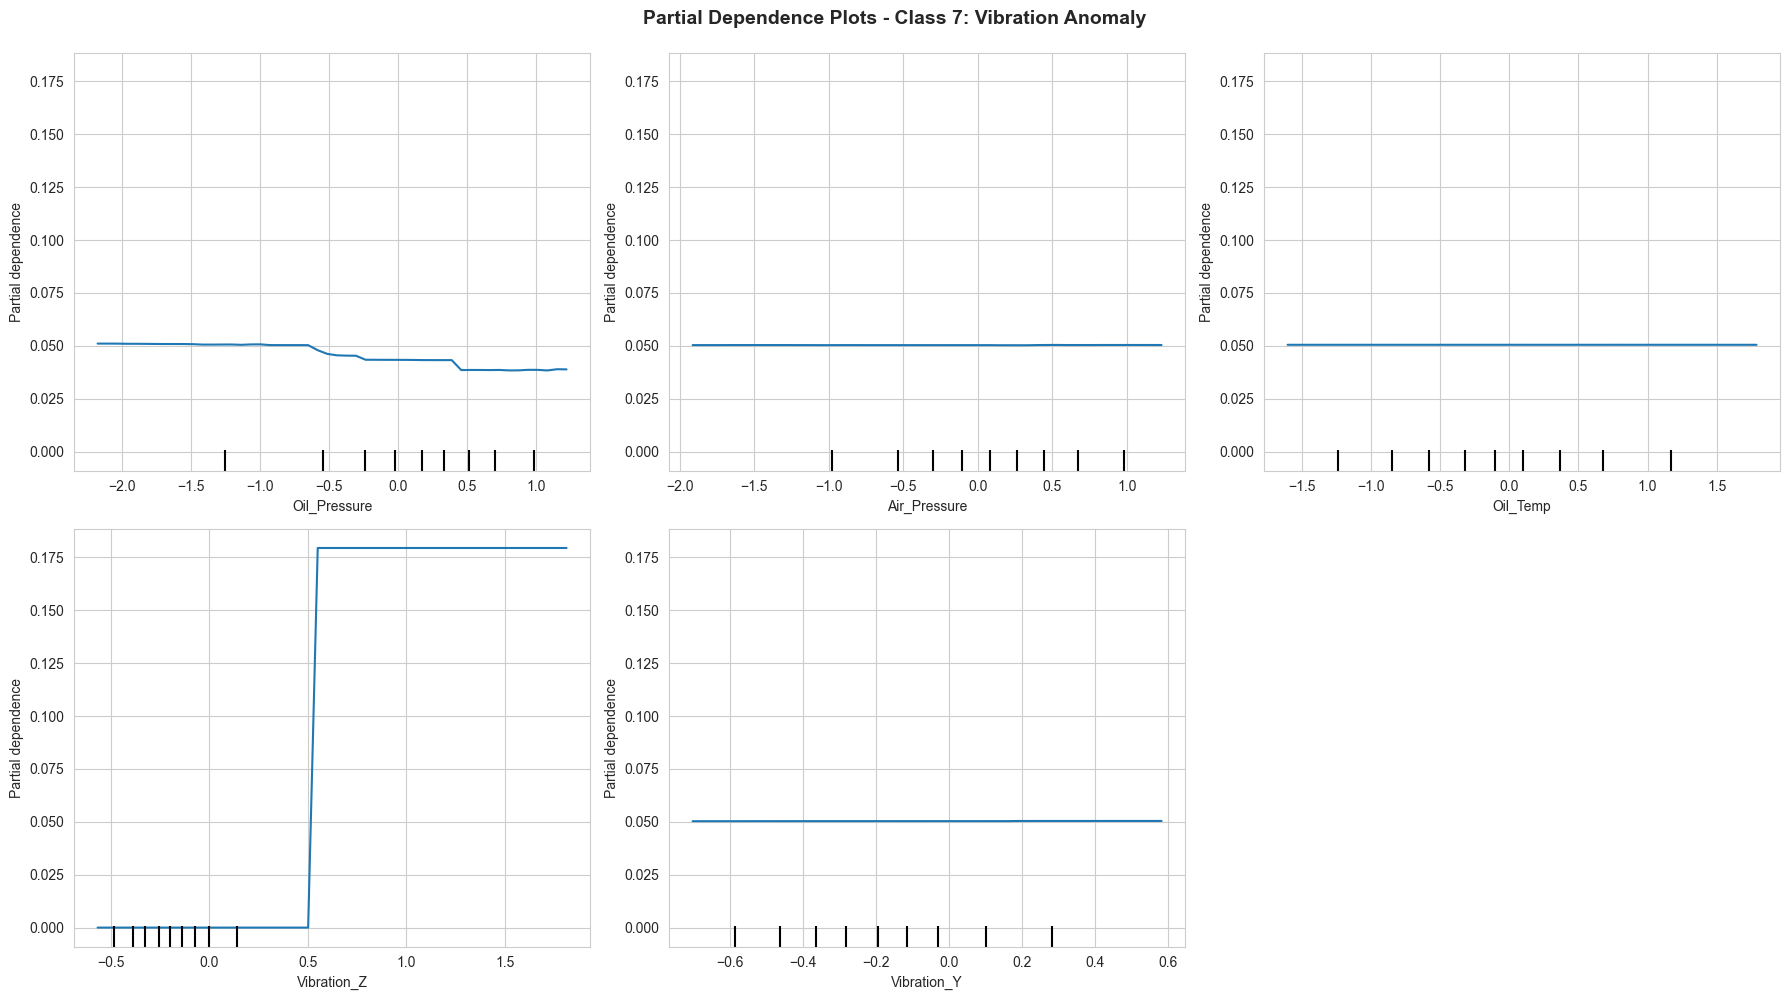


âœ“ Partial Dependence Plots generated for all classes


In [12]:
# Generate Partial Dependence Plots for top 5 features
print("Generating Partial Dependence Plots for top 5 features...")
print("=" * 80)

# Get feature indices for top 5 features
top_5_indices = [sensor_features.index(feat) for feat in top_5_features]

# Create PDP for each of the 8 classes
for class_idx in range(8):
    print(f"\nGenerating PDP for Class {class_idx}: {FAULT_LABELS[class_idx]}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Generate PDP for top 5 features
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_test_scaled_df,
        features=top_5_indices,
        target=class_idx,
        feature_names=sensor_features,
        grid_resolution=50,
        ax=axes[:5]
    )
    
    # Remove the extra subplot
    fig.delaxes(axes[5])
    
    plt.suptitle(f'Partial Dependence Plots - Class {class_idx}: {FAULT_LABELS[class_idx]}',
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

print("\nâœ“ Partial Dependence Plots generated for all classes")

In [13]:
from IPython.display import display, Markdown

# Generate interpretation guidelines with dynamic top features
top_features_text = "**, **".join(top_5_features)

interpretation_md = f"""
## 7. Interpretation Guidelines

### Understanding SHAP Values

**What are SHAP values?**
- SHAP (SHapley Additive exPlanations) values represent the contribution of each feature to a prediction
- Based on game theory (Shapley values) - a fair way to distribute credit among features
- **Positive SHAP value**: Feature pushes prediction toward that class
- **Negative SHAP value**: Feature pushes prediction away from that class
- **Magnitude**: Indicates strength of the feature's influence

### How to Read the Visualizations

**1. Beeswarm Plot (Summary Plot)**
- Features are ranked by importance (top = most important)
- Each dot represents one prediction
- X-axis: SHAP value (impact on model output)
- Color: Feature value (red = high, blue = low)
- **Example**: If high Oil_Temp (red dots) appears on the right side for "Lubrication Oil Degradation", it means high oil temperature strongly predicts this fault

**2. Bar Plot (Mean Absolute SHAP)**
- Shows average magnitude of each feature's impact
- Longer bar = more important feature globally
- Useful for quick feature ranking

**3. Partial Dependence Plots (PDP)**
- Shows how changing one feature affects the prediction
- X-axis: Feature value
- Y-axis: Predicted probability for that class
- **Example**: If PDP for Vibration_X shows upward slope for "Vibration Anomaly", higher vibration increases fault probability

### Practical Application for Engineers

**Scenario 1: Normal Operation**
- SHAP values should be mostly negative for fault classes
- Features like normal RPM, temperature, and pressure push predictions away from faults

**Scenario 2: Fault Detected**
- Identify which features have high positive SHAP values for the predicted fault
- These are the sensors showing abnormal readings driving the diagnosis
- Focus maintenance efforts on systems related to these features

**Scenario 3: Uncertain Prediction**
- If multiple classes have similar probabilities, check SHAP values
- Features with conflicting signals may indicate early-stage fault or sensor issues
- Consider additional diagnostics or monitoring

### Key Insights from This Analysis

Based on the SHAP analysis, the most influential features for fault detection are:
1. **{top_features_text}**

These features should be:
- Monitored most closely in real-time operations
- Calibrated and maintained with highest priority
- Used as primary indicators in maintenance decision-making

### Limitations and Considerations

- SHAP values explain the model's predictions, not necessarily true causality
- Feature interactions may not be fully captured in individual SHAP values
- Scaled features: SHAP values are computed on standardized data
- Model-dependent: SHAP explains this specific LightGBM model's behavior

### Recommended Actions

1. **For Operations**: Use SHAP values in the dashboard to understand why a fault was predicted
2. **For Maintenance**: Prioritize inspections based on features with high SHAP values
3. **For Engineering**: Use PDP plots to set optimal operating ranges
4. **For Model Improvement**: Features with low SHAP values across all classes may be candidates for removal
"""

display(Markdown(interpretation_md))


## 7. Interpretation Guidelines

### Understanding SHAP Values

**What are SHAP values?**
- SHAP (SHapley Additive exPlanations) values represent the contribution of each feature to a prediction
- Based on game theory (Shapley values) - a fair way to distribute credit among features
- **Positive SHAP value**: Feature pushes prediction toward that class
- **Negative SHAP value**: Feature pushes prediction away from that class
- **Magnitude**: Indicates strength of the feature's influence

### How to Read the Visualizations

**1. Beeswarm Plot (Summary Plot)**
- Features are ranked by importance (top = most important)
- Each dot represents one prediction
- X-axis: SHAP value (impact on model output)
- Color: Feature value (red = high, blue = low)
- **Example**: If high Oil_Temp (red dots) appears on the right side for "Lubrication Oil Degradation", it means high oil temperature strongly predicts this fault

**2. Bar Plot (Mean Absolute SHAP)**
- Shows average magnitude of each feature's impact
- Longer bar = more important feature globally
- Useful for quick feature ranking

**3. Partial Dependence Plots (PDP)**
- Shows how changing one feature affects the prediction
- X-axis: Feature value
- Y-axis: Predicted probability for that class
- **Example**: If PDP for Vibration_X shows upward slope for "Vibration Anomaly", higher vibration increases fault probability

### Practical Application for Engineers

**Scenario 1: Normal Operation**
- SHAP values should be mostly negative for fault classes
- Features like normal RPM, temperature, and pressure push predictions away from faults

**Scenario 2: Fault Detected**
- Identify which features have high positive SHAP values for the predicted fault
- These are the sensors showing abnormal readings driving the diagnosis
- Focus maintenance efforts on systems related to these features

**Scenario 3: Uncertain Prediction**
- If multiple classes have similar probabilities, check SHAP values
- Features with conflicting signals may indicate early-stage fault or sensor issues
- Consider additional diagnostics or monitoring

### Key Insights from This Analysis

Based on the SHAP analysis, the most influential features for fault detection are:
1. **Oil_Pressure**, **Air_Pressure**, **Oil_Temp**, **Vibration_Z**, **Vibration_Y**

These features should be:
- Monitored most closely in real-time operations
- Calibrated and maintained with highest priority
- Used as primary indicators in maintenance decision-making

### Limitations and Considerations

- SHAP values explain the model's predictions, not necessarily true causality
- Feature interactions may not be fully captured in individual SHAP values
- Scaled features: SHAP values are computed on standardized data
- Model-dependent: SHAP explains this specific LightGBM model's behavior

### Recommended Actions

1. **For Operations**: Use SHAP values in the dashboard to understand why a fault was predicted
2. **For Maintenance**: Prioritize inspections based on features with high SHAP values
3. **For Engineering**: Use PDP plots to set optimal operating ranges
4. **For Model Improvement**: Features with low SHAP values across all classes may be candidates for removal


## 8. Example: Local Explanation for Individual Predictions

Let's examine SHAP values for a few specific test samples to demonstrate local explanations.

In [14]:
# Select a few interesting samples from different classes
sample_indices = []
for class_idx in range(8):
    # Find a sample from this class
    class_samples = np.where(y_test == class_idx)[0]
    if len(class_samples) > 0:
        sample_indices.append(class_samples[0])

print(f"Selected {len(sample_indices)} sample predictions for local explanation")
print("=" * 80)

Selected 8 sample predictions for local explanation



Sample 1:
  True Label: 0 (Normal)
  Predicted Label: 0 (Normal)
  Match: âœ“


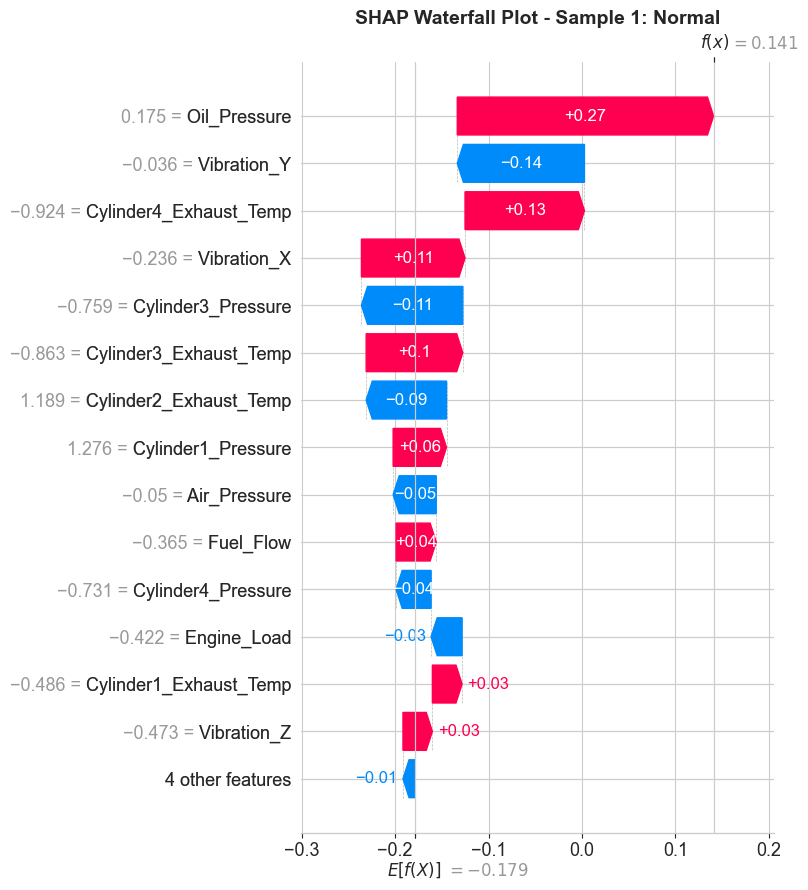


Sample 2:
  True Label: 1 (Fuel Injection Fault)
  Predicted Label: 0 (Normal)
  Match: âœ—


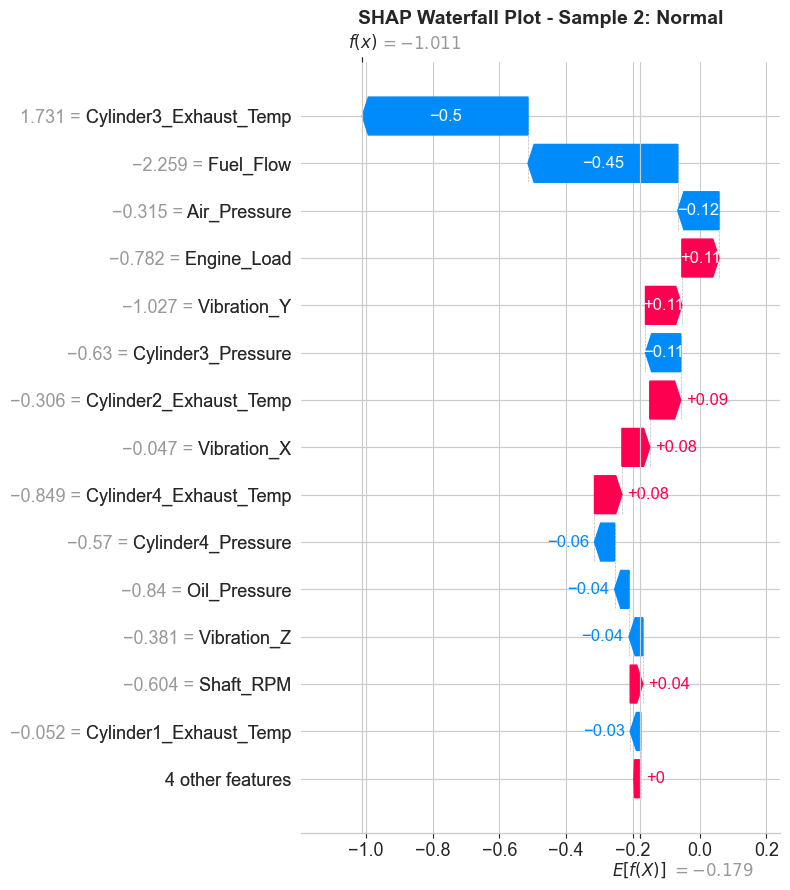


Sample 3:
  True Label: 2 (Cooling System Fault)
  Predicted Label: 2 (Cooling System Fault)
  Match: âœ“


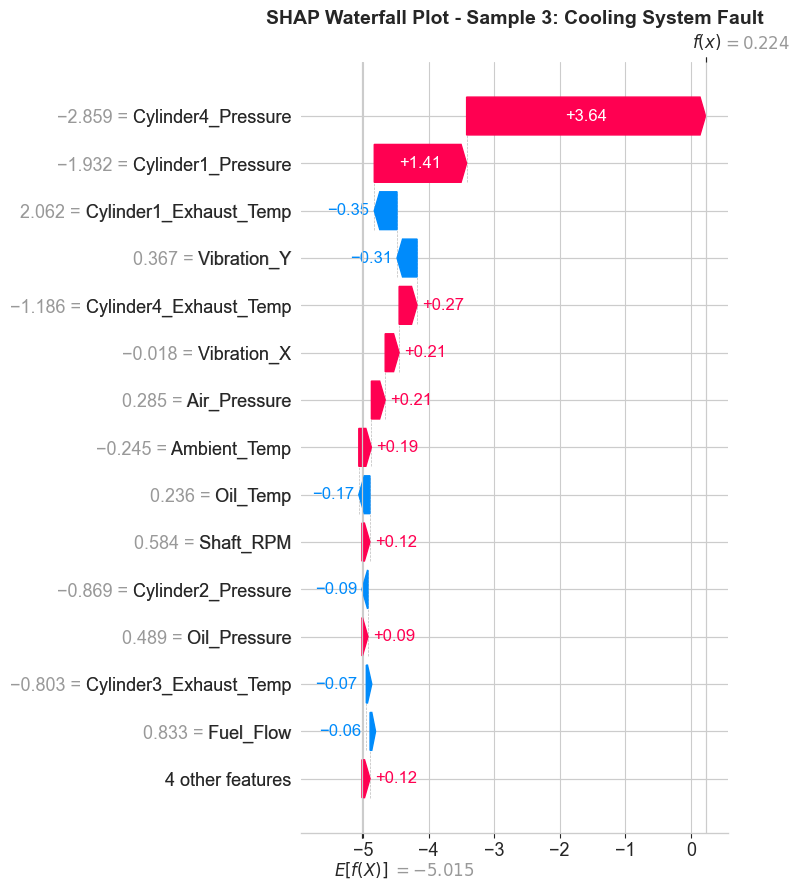

In [15]:
# Display local SHAP explanation for first 3 samples
for i, sample_idx in enumerate(sample_indices[:3]):
    true_label = y_test.iloc[sample_idx]
    pred_label = model.predict(X_test_scaled[sample_idx:sample_idx+1])[0]
    
    print(f"\nSample {i+1}:")
    print(f"  True Label: {true_label} ({FAULT_LABELS[true_label]})")
    print(f"  Predicted Label: {pred_label} ({FAULT_LABELS[pred_label]})")
    print(f"  Match: {'âœ“' if true_label == pred_label else 'âœ—'}")
    
    # Show SHAP waterfall plot for the predicted class
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[pred_label][sample_idx],
            base_values=explainer.expected_value[pred_label],
            data=X_test_scaled_df.iloc[sample_idx],
            feature_names=sensor_features
        ),
        max_display=15,
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Sample {i+1}: {FAULT_LABELS[pred_label]}',
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 9. Save SHAP Explainer for Deployment

Saving the SHAP explainer so it can be loaded by the FastAPI backend for real-time explanation generation.

In [16]:
# Save the SHAP explainer
explainer_path = '../backend/artifacts/shap_explainer.pkl'
joblib.dump(explainer, explainer_path)

print(f"âœ“ SHAP explainer saved to: {explainer_path}")
print(f"File size: {os.path.getsize(explainer_path) / 1024:.2f} KB")

âœ“ SHAP explainer saved to: ../backend/artifacts/shap_explainer.pkl
File size: 26801.98 KB


In [17]:
# Verify the saved explainer by loading it back
loaded_explainer = joblib.load(explainer_path)

print("\nVerifying saved SHAP explainer:")
print("=" * 80)
print(f"Explainer type: {type(loaded_explainer).__name__}")
print(f"Expected value shape: {np.array(loaded_explainer.expected_value).shape}")

# Test SHAP computation with loaded explainer
test_sample = X_test_scaled[:3]
original_shap_raw = explainer.shap_values(test_sample)
loaded_shap_raw = loaded_explainer.shap_values(test_sample)

# Convert to same format for comparison
if isinstance(original_shap_raw, np.ndarray) and len(original_shap_raw.shape) == 3:
    original_shap_list = [original_shap_raw[:, :, i] for i in range(original_shap_raw.shape[2])]
else:
    original_shap_list = original_shap_raw

if isinstance(loaded_shap_raw, np.ndarray) and len(loaded_shap_raw.shape) == 3:
    loaded_shap_list = [loaded_shap_raw[:, :, i] for i in range(loaded_shap_raw.shape[2])]
else:
    loaded_shap_list = loaded_shap_raw

# Check if SHAP values match across all classes
shap_match = all([np.allclose(original_shap_list[i], loaded_shap_list[i]) for i in range(len(original_shap_list))])
print(f"SHAP values match: {shap_match}")

if shap_match:
    print("\nâœ“ SHAP explainer saved and verified successfully!")


Verifying saved SHAP explainer:
Explainer type: TreeExplainer
Expected value shape: (8,)
SHAP values match: True

âœ“ SHAP explainer saved and verified successfully!


In [18]:
# Generate summary with dynamic top features
top_features_text = "**, **".join(top_5_features)

summary_md = f"""
## 10. Summary

### Explainability Analysis Complete!

**What we accomplished:**

1. âœ“ Loaded trained LightGBM model and test data
2. âœ“ Initialized SHAP TreeExplainer
3. âœ“ Computed SHAP values for entire test set
4. âœ“ Generated global SHAP summary plots (beeswarm) for all 8 fault classes
5. âœ“ Generated SHAP bar plots showing mean absolute SHAP values
6. âœ“ Created Partial Dependence Plots for top 5 most important features
7. âœ“ Documented interpretation guidelines for engineers
8. âœ“ Demonstrated local explanations with waterfall plots
9. âœ“ Saved SHAP explainer to `backend/artifacts/shap_explainer.pkl`

**Key Findings:**

- Top 5 most influential features identified: **{top_features_text}**
- SHAP values provide both global and local explanations
- Partial Dependence Plots reveal feature-prediction relationships
- Explainer ready for deployment in FastAPI backend

**Artifacts Created:**

- `backend/artifacts/preprocessor.pkl` (from notebook 02)
- `backend/artifacts/lgbm_model.pkl` (from notebook 03)
- `backend/artifacts/shap_explainer.pkl` (this notebook)

**Next Steps:**

All machine learning artifacts are now ready for deployment. The next phase involves:
1. Building the FastAPI backend to serve predictions with SHAP explanations
2. Creating the React frontend for the Engineer's Dashboard
3. Integrating all components for end-to-end functionality
4. Testing with demo scenarios (Normal, Minor Fault, Critical Fault)
"""

display(Markdown(summary_md))


## 10. Summary

### Explainability Analysis Complete!

**What we accomplished:**

1. âœ“ Loaded trained LightGBM model and test data
2. âœ“ Initialized SHAP TreeExplainer
3. âœ“ Computed SHAP values for entire test set
4. âœ“ Generated global SHAP summary plots (beeswarm) for all 8 fault classes
5. âœ“ Generated SHAP bar plots showing mean absolute SHAP values
6. âœ“ Created Partial Dependence Plots for top 5 most important features
7. âœ“ Documented interpretation guidelines for engineers
8. âœ“ Demonstrated local explanations with waterfall plots
9. âœ“ Saved SHAP explainer to `backend/artifacts/shap_explainer.pkl`

**Key Findings:**

- Top 5 most influential features identified: **Oil_Pressure**, **Air_Pressure**, **Oil_Temp**, **Vibration_Z**, **Vibration_Y**
- SHAP values provide both global and local explanations
- Partial Dependence Plots reveal feature-prediction relationships
- Explainer ready for deployment in FastAPI backend

**Artifacts Created:**

- `backend/artifacts/preprocessor.pkl` (from notebook 02)
- `backend/artifacts/lgbm_model.pkl` (from notebook 03)
- `backend/artifacts/shap_explainer.pkl` (this notebook)

**Next Steps:**

All machine learning artifacts are now ready for deployment. The next phase involves:
1. Building the FastAPI backend to serve predictions with SHAP explanations
2. Creating the React frontend for the Engineer's Dashboard
3. Integrating all components for end-to-end functionality
4. Testing with demo scenarios (Normal, Minor Fault, Critical Fault)
